#Cycle GAN Architechture Implementation

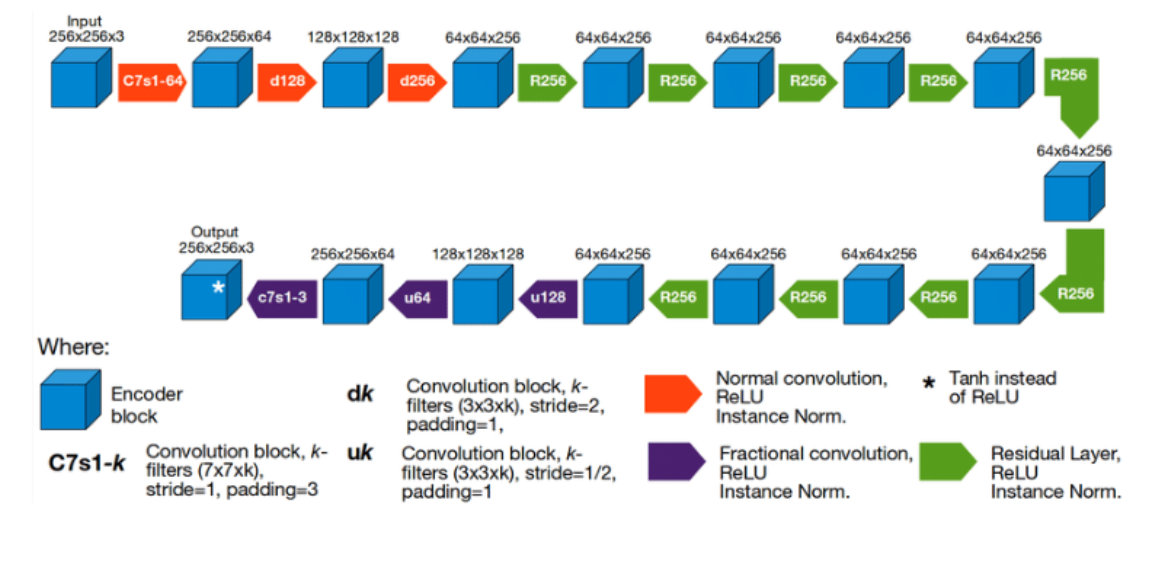



In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [2]:
def residual_block(x, filters):
    init = x
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.InstanceNormalization()(x)

    return layers.Add()([init, x])

In [3]:
# Built architechture based on the diagram shown above
def build_generator(input_shape, num_residual_blocks=9):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=7, strides=1, padding='same')(inputs)
    x = layers.InstanceNormalization()(x)
    x = layers.ReLU()(x)

    filters = 64
    for i in range(2):
        filters = filters * 2
        x = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same')(x)
        x = layers.InstanceNormalization()(x)
        x = layers.ReLU()(x)

    for i in range(num_residual_blocks):
        x = residual_block(x, filters)

    for _ in range(2):
        filters //= 2
        x = layers.Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same')(x)
        x = layers.InstanceNormalization()(x)
        x = layers.ReLU()(x)

    x = layers.Conv2D(3, kernel_size=7, strides=1, padding='same')(x)
    x = layers.Activation('tanh')(x)

    return models.Model(inputs, x)

In [4]:
def build_discriminator(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)

    filters = 64
    for i in range(3):
        filters = filter * 2
        x = layers.Conv2D(filters, kernel_size=4, strides=2, padding='same')(x)
        x = layers.InstanceNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(x)

    return models.Model(inputs, x)


In [5]:
#based on the paper
def cycle_consistency_loss(real_image, cycled_image, lambda_cycle=10.0):
    c_loss = lambda_cycle * K.mean(K.abs(real_image - cycled_image))
    return c_loss

def adversarial_loss(real, fake):
    a_loss = K.mean(K.square(real - fake))
    return a_loss


In [6]:
class CycleGAN:
    def __init__(self, img_shape):
        self.img_shape = img_shape


        self.D_A = self.build_discriminator()
        self.D_B = self.build_discriminator()
        self.D_A.compile(loss='mse', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
        self.D_B.compile(loss='mse', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

        self.G_AB = self.build_generator()
        self.G_BA = self.build_generator()

        img_A = layers.Input(shape=img_shape)
        img_B = layers.Input(shape=img_shape)

        # Generators convert A -> B and B -> A
        fake_B = self.G_AB(img_A)
        fake_A = self.G_BA(img_B)

        # Cycled images (A -> B -> A) and (B -> A -> B)
        cycle_A = self.G_BA(fake_B)
        cycle_B = self.G_AB(fake_A)

        # Discriminators are frozen during generator training
        self.D_A.trainable = False
        self.D_B.trainable = False

        valid_A = self.D_A(fake_A)
        valid_B = self.D_B(fake_B)

        #combined model based on the paper
        self.combined = models.Model(inputs=[img_A, img_B],
                                     outputs=[valid_A, valid_B, cycle_A, cycle_B])
        self.combined.compile(loss=['mse', 'mse', 'mae', 'mae'],
                              loss_weights=[1, 1, 10, 10],
                              optimizer=Adam(0.0002, 0.5))

    def build_generator(self):
        return build_generator(self.img_shape)

    def build_discriminator(self):
        return build_discriminator(self.img_shape)


In [7]:
import numpy as np

def load_data(batch_size):
    # Load your images here and preprocess
    pass

def train(epochs, batch_size):
    gan = CycleGAN((128, 128, 3))

    epochs = 10
    for epoch in range(epochs):
        for batch_i, (imgs_A, imgs_B) in enumerate(load_data(batch_size)):
            fake_B = gan.G_AB.predict(imgs_A)
            fake_A = gan.G_BA.predict(imgs_B)

            dA_loss_real = gan.D_A.train_on_batch(imgs_A, np.ones((batch_size, 16, 16, 1)))
            dA_loss_fake = gan.D_A.train_on_batch(fake_A, np.zeros((batch_size, 16, 16, 1)))
            dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

            dB_loss_real = gan.D_B.train_on_batch(imgs_B, np.ones((batch_size, 16, 16, 1)))
            dB_loss_fake = gan.D_B.train_on_batch(fake_B, np.zeros((batch_size, 16, 16, 1)))
            dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

            # Discriminator Loss
            d_loss = 0.5 * np.add(dA_loss, dB_loss)
            # Generator loss i.e., cycle loss and adversarial loss
            g_loss = gan.combined.train_on_batch([imgs_A, imgs_B], [np.ones((batch_size, 16, 16, 1)), np.ones((batch_size, 16, 16, 1)), imgs_A, imgs_B])
            # Print the progress
            print(f"[Epoch {epoch}/{epochs}] [D loss: {d_loss[0]}] [G loss: {g_loss}]")
